In [6]:
from pathlib import Path
import pandas as pd

REPO_ROOT = Path.cwd().parent
OUT = REPO_ROOT / "outputs" / "rtm"

exp = pd.read_parquet(OUT / "water_exposure_Ehat_v0.parquet")
haz = pd.read_parquet(OUT / "hazard_pluvial_v0.parquet")
out = pd.read_parquet(OUT / "outcome_damage_v0.parquet")

df = exp.merge(haz, on="bldg_id").merge(out, on="bldg_id")
len(df)


221324

In [7]:
import pymc as pm
import arviz as az
import numpy as np

rng = np.random.default_rng(42)
n = len(df)
idx = rng.choice(n, size=3000, replace=False)

E = df["E_hat"].to_numpy()[idx]
H = df["H_pluvial_v0"].to_numpy()[idx]
Y = df["Y_damage_v0"].to_numpy()[idx]

print("Using n =", len(Y))

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_E = pm.Normal("beta_E", mu=0, sigma=1)
    beta_H = pm.Normal("beta_H", mu=0, sigma=1)

    logit_p = alpha + beta_E * E + beta_H * H

    y_obs = pm.Bernoulli(
        "y_obs",
        logit_p=logit_p,
        observed=Y,
    )

    approx = pm.fit(
        n=8_000,
        method="advi",
        random_seed=42,
        progressbar=True,
    )

    trace = approx.sample(500)


Using n = 3000


Finished [100%]: Average Loss = 1,144.3


In [8]:
az.summary(trace, var_names=["alpha", "beta_E", "beta_H"])


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.038,0.269,-1.504,-0.507,0.013,0.009,439.0,436.0,NaN
beta_E,0.948,0.236,0.432,1.315,0.010,0.007,526.0,353.0,NaN
beta_H,-1.042,0.278,-1.493,-0.454,0.012,0.009,533.0,462.0,NaN


Sampling: [y_obs]


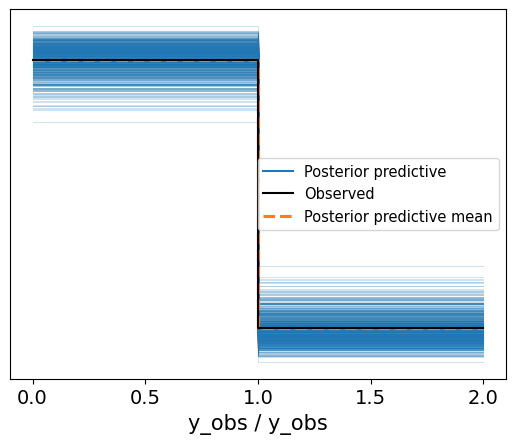

In [12]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=["y_obs"],
        random_seed=42,
    )

az.plot_ppc(ppc);
